In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import keras
import skimage
from skimage import exposure
from skimage.transform import resize

## Data Preprocessing

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [ ]:
# check the input structure
keras.backend.image_data_format()

'channels_last'

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    X = []
    y = []
    
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        for img in os.listdir(path):
            try:
                # use cv2.imread() to read an image
                img_arr = cv2.imread(os.path.join(path, img)) # cv2.IMREAD_COLOR
                # reshape images to preferred size
                resized_arr = skimage.transform.resize(img_arr, (img_size, img_size, 3)) 
                resized_arr = np.asarray(resized_arr)
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [ ]:
# Load the dataset
x_train, y_train = get_training_data('C:/Users/17733/OneDrive - The University of Chicago/MSCA 37011 Deep Learning & Image Recognition/Final Project/dataset/chest_xray/train')
x_test, y_test = get_training_data('C:/Users/17733/OneDrive - The University of Chicago/MSCA 37011 Deep Learning & Image Recognition/Final Project/dataset/chest_xray/test')
x_val, y_val = get_training_data('C:/Users/17733/OneDrive - The University of Chicago/MSCA 37011 Deep Learning & Image Recognition/Final Project/dataset/chest_xray/val')

In [ ]:
# Check train and test dataset shape
print(x_train.shape, '\n', x_test.shape, '\n', x_val.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3) 
 (16, 150, 150, 3)


In [ ]:
print(y_train.shape, '\n', y_test.shape, '\n', y_val.shape)

(5216,) 
 (624,) 
 (16,)


In [ ]:
y_train[1]

In [ ]:
# Preview the images in train dataset of both the classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Pneumonia vs. Normal')
ax1.imshow(x_train, cmap='gray')
ax2.imshow(train[-1][0], cmap='gray')

## Addressing Imbalanced Class Problem

- Undersampling & Oversampling & combined over/under sampling
- ImageDataGenerator across both class
- Image augmenters on only normal(minority) class
- Adjusting weights for different classes

In [ ]:
# Check the class labels in the train dataset
from collections import Counter
Counter(y_train.flatten())

Counter({0: 3875, 1: 1341})

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

<AxesSubplot:ylabel='count'>

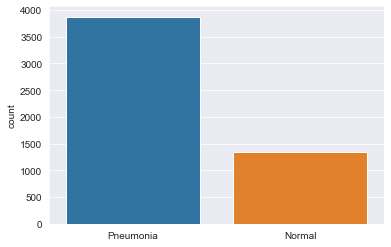

In [ ]:
count_class = []
for i in y_train:
    if(i == 0):
        count_class.append("Pneumonia")
    else:
        count_class.append("Normal")
        
sns.set_style('darkgrid')
sns.countplot(count_class)    

#### 1) Over/Under Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
# Reshape dataset for over/under sampling
x_train_arr = np.concatenate(x_train).ravel()
x_train_arr = x_train_arr.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])

x_test_arr = np.concatenate(x_test).ravel()
x_test_arr = x_test_arr.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

x_val_arr = np.concatenate(x_val).ravel()
x_val_arr = x_val_arr.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2] * x_val.shape[3])

In [ ]:
# The default for sampling strategy is 'auto'; in smote case, resample all classes but the majority class; in undersampling, resample all classes but the minority class
over = SMOTE()
under = RandomUnderSampler()

X_combined_sampling, y_combined_sampling = over.fit_resample(x_train_arr, y_train)
X_combined_sampling, y_combined_sampling = under.fit_resample(X_combined_sampling, y_combined_sampling)

# Reshape data back to 3 channels
X_combined_sampling = X_combined_sampling.reshape(X_combined_sampling.shape[0], img_size, img_size, 3)

In [ ]:
# new class distribution
print(Counter(y_combined_sampling))

Counter({0: 3875, 1: 3875})


#### 2) ImageDataGenerator
These transformations are done under the ImageDataGenerator:

- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally.

In [ ]:
# Apply the ImageDataGenerator method
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # boolean, to set input mean to 0 over the dataset
        samplewise_center=False,  # boolean, to set each sample mean to 0
        featurewise_std_normalization=False,  # boolean, to divide inputs by std of the dataset
        samplewise_std_normalization=False,  # boolean, to divide each input by its std
        zca_whitening=False,  # boolean, to apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # # boolean, to randomly flip images horizontally
        vertical_flip=False)  # # boolean, to randomly flip images vertically

datagen.fit(x_train)

#### 3) Image Augmenter

In [ ]:
import imgaug.augmenters as iaa

# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) # random brightness

def image_aug(feature, label, batch_size):
    # Get total number of samples in the data
    n = len(feature)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 150, 150, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,1), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img = feature[idx]
            l = label[idx]
            
            batch_data[count] = img
            batch_labels[count] = l
            
            # generating more samples of the undersampled class
            if np.logical_and(l== 1,count < batch_size-2):
                img = img.astype(np.uint8)
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = l
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = l
                count += 2
            
            else:
                count+=1
            
            if count== batch_size-1:
                break
            
        i+=1
        batch_data = batch_data.reshape(batch_size,150,150,3)
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

#### 4) Adjusting Class Weights

In [ ]:
# Pneumonia class is about 2.8 greater than Normal class
from sklearn.utils import class_weight
class_weight = {0: 1.,1: 2.8}  

## Modeling

### 1) CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

cnn_model = Sequential()
cnn_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128 , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units = 1 , activation = 'sigmoid'))

# Display all the model's layers
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [ ]:
# Reduce learning rate when a metric has stopped improving
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', # quantity to be monitored.
                                            patience = 2, # number of epochs with no improvement after which learning rate will be reduced
                                            verbose = 1, 
                                            factor = 0.3, # factor by which the learning rate will be reduced (new_lr = lr * factor)
                                            min_lr = 0.0001)

# Interrupt trainning when no progress on the validation set for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

# Create a callback list
callback_list = [learning_rate_reduction, early_stopping]

1) Fit CNN with Over/Under Sampling Data

In [ ]:
# Clone original CNN model for Over/Under Sampling Data
cnn_model_OUS = keras.models.clone_model(cnn_model)
cnn_model_OUS.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# Fit model
history_cnn_1 = cnn_model_OUS.fit(X_combined_sampling, y_combined_sampling,
                                  validation_data = (x_val, y_val),
                                  epochs = 10,
                                  callbacks = callback_list)

Epoch 1/10
243/243 [==============================] - 173s 710ms/step - loss: 0.4810 - accuracy: 0.9032 - val_loss: 5.0256 - val_accuracy: 0.5000
Epoch 2/10
243/243 [==============================] - 170s 698ms/step - loss: 0.1130 - accuracy: 0.9653 - val_loss: 4.3862 - val_accuracy: 0.5625
Epoch 3/10
243/243 [==============================] - 172s 707ms/step - loss: 0.0871 - accuracy: 0.9760 - val_loss: 0.1901 - val_accuracy: 0.9375
Epoch 4/10
243/243 [==============================] - 172s 707ms/step - loss: 0.0689 - accuracy: 0.9803 - val_loss: 0.4500 - val_accuracy: 0.7500
Epoch 5/10
243/243 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9858
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 [==============================] - 181s 746ms/step - loss: 0.0510 - accuracy: 0.9858 - val_loss: 0.1994 - val_accuracy: 0.9375
Epoch 6/10
243/243 [==============================] - 182s 751ms/step - loss: 0.0161 - accuracy: 0.9945 -

In [ ]:
# Save model
cnn_model_OUS.save('cnn_model_OUS.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", cnn_model_OUS.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", cnn_model_OUS.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 1s 75ms/step - loss: 3.1908 - accuracy: 0.7660
Loss of the model is -  3.1908249855041504
20/20 [==============================] - 1s 74ms/step - loss: 3.1908 - accuracy: 0.7660
Accuracy of the model is -  76.60256624221802 %


In [ ]:
def plot_accuracy(epoch, history):    
    epochs = [i for i in range(epoch)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('CNN Model on Over/Under Sampling Data')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

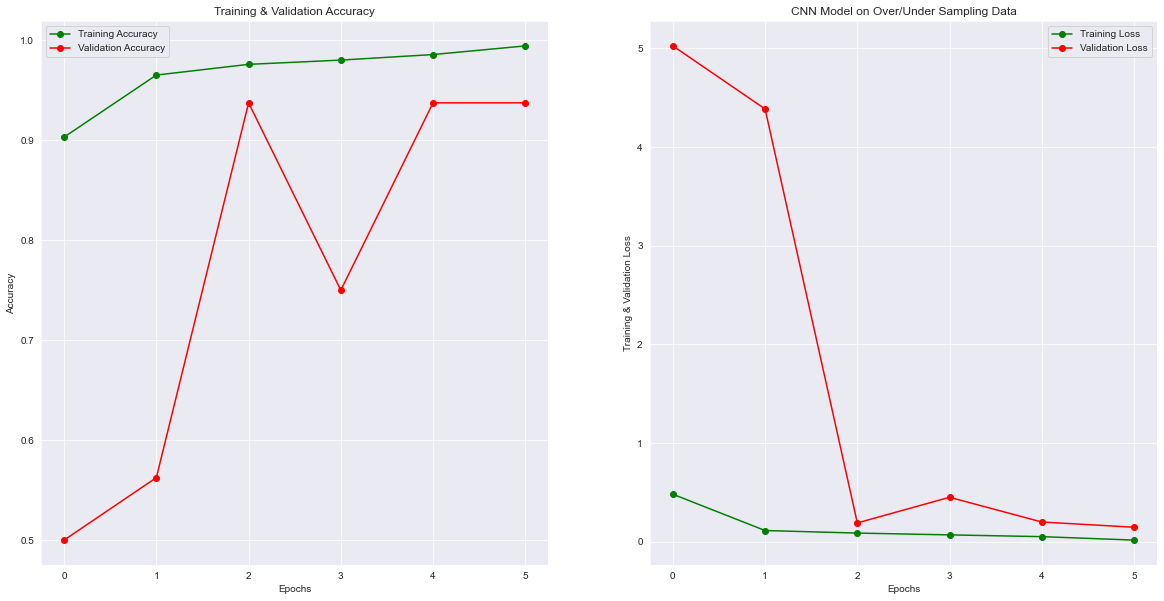

In [ ]:
plot_accuracy(6, history_cnn_1)

2) Fit CNN with ImageDataGenerator

In [ ]:
# Clone original CNN model for ImageDataGenerator
cnn_model_IDG = keras.models.clone_model(cnn_model)
cnn_model_IDG.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
 
# Fit model
history_cnn_2 = cnn_model_IDG.fit(datagen.flow(x_train, y_train, batch_size = 32),
                                  validation_data = datagen.flow(x_val, y_val),
                                  epochs = 12, 
                                  callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 126s 773ms/step - loss: 0.5839 - accuracy: 0.8232 - val_loss: 25.4756 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 121s 744ms/step - loss: 0.2981 - accuracy: 0.8775 - val_loss: 25.8340 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2579 - accuracy: 0.9103
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 122s 747ms/step - loss: 0.2579 - accuracy: 0.9103 - val_loss: 4.9073 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 124s 760ms/step - loss: 0.1776 - accuracy: 0.9388 - val_loss: 0.7912 - val_accuracy: 0.5625
Epoch 5/12
163/163 [==============================] - 123s 753ms/step - loss: 0.1485 - accuracy: 0.9442 - val_loss: 3.7368 - val_accuracy: 0.5625
Epoch 6/12
163/163 [==============================] - 122s 751ms/step - loss: 0.1387 - accuracy: 0.9490

In [ ]:
# Save model
cnn_model_IDG.save('cnn_model_IDG.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", cnn_model_IDG.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", cnn_model_IDG.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 2s 76ms/step - loss: 0.5987 - accuracy: 0.8862
Loss of the model is -  0.5986734628677368
20/20 [==============================] - 2s 77ms/step - loss: 0.5987 - accuracy: 0.8862
Accuracy of the model is -  88.62179517745972 %


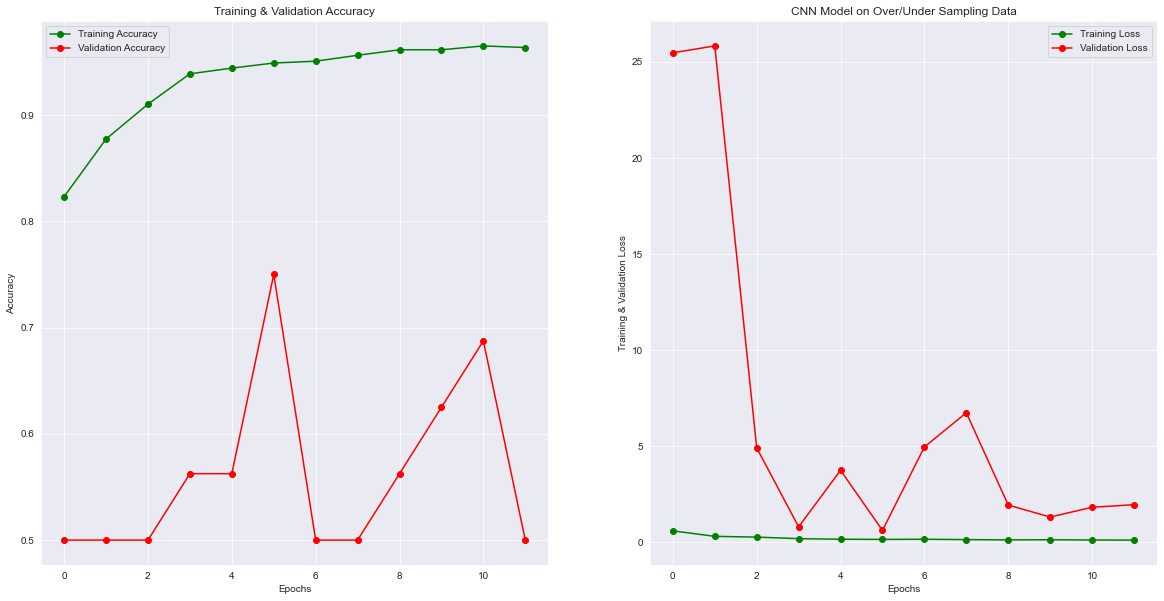

In [ ]:
plot_accuracy(12, history_cnn_2)

3) Fit CNN with Image Augmenter

In [ ]:
# Clone original CNN model for Image Augmenter
cnn_model_IA = keras.models.clone_model(cnn_model)
cnn_model_IA.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

batch_size = 16
nb_train_steps = x_train.shape[0]//batch_size
train_data_gen = image_aug(x_train, y_train, batch_size)

# Fit model
history_cnn_3 = cnn_model_IA.fit_generator(train_data_gen, 
                                           epochs=10, 
                                           steps_per_epoch=nb_train_steps,
                                           validation_data=(x_val, y_val),
                                           callbacks = callback_list)

Epoch 1/10
326/326 [==============================] - 126s 386ms/step - loss: 0.5016 - accuracy: 0.8953 - val_loss: 11.7774 - val_accuracy: 0.5000
Epoch 2/10
326/326 [==============================] - 123s 377ms/step - loss: 0.1516 - accuracy: 0.9603 - val_loss: 0.8588 - val_accuracy: 0.7500
Epoch 3/10
326/326 [==============================] - 123s 378ms/step - loss: 0.1315 - accuracy: 0.9680 - val_loss: 2.1042 - val_accuracy: 0.5625
Epoch 4/10
326/326 [==============================] - 125s 383ms/step - loss: 0.0931 - accuracy: 0.9758 - val_loss: 0.1391 - val_accuracy: 0.9375
Epoch 5/10
326/326 [==============================] - 124s 380ms/step - loss: 0.0851 - accuracy: 0.9799 - val_loss: 0.6307 - val_accuracy: 0.7500
Epoch 6/10
326/326 [==============================] - 125s 382ms/step - loss: 0.0668 - accuracy: 0.9814 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 7/10
326/326 [==============================] - 126s 385ms/step - loss: 0.0792 - accuracy: 0.9808 - val_loss: 0.8030 

In [ ]:
# Save model
cnn_model_IA.save('cnn_model_IA.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", cnn_model_IA.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", cnn_model_IA.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 2s 79ms/step - loss: 4.1160 - accuracy: 0.7276
Loss of the model is -  4.116002559661865
20/20 [==============================] - 2s 76ms/step - loss: 4.1160 - accuracy: 0.7276
Accuracy of the model is -  72.75640964508057 %


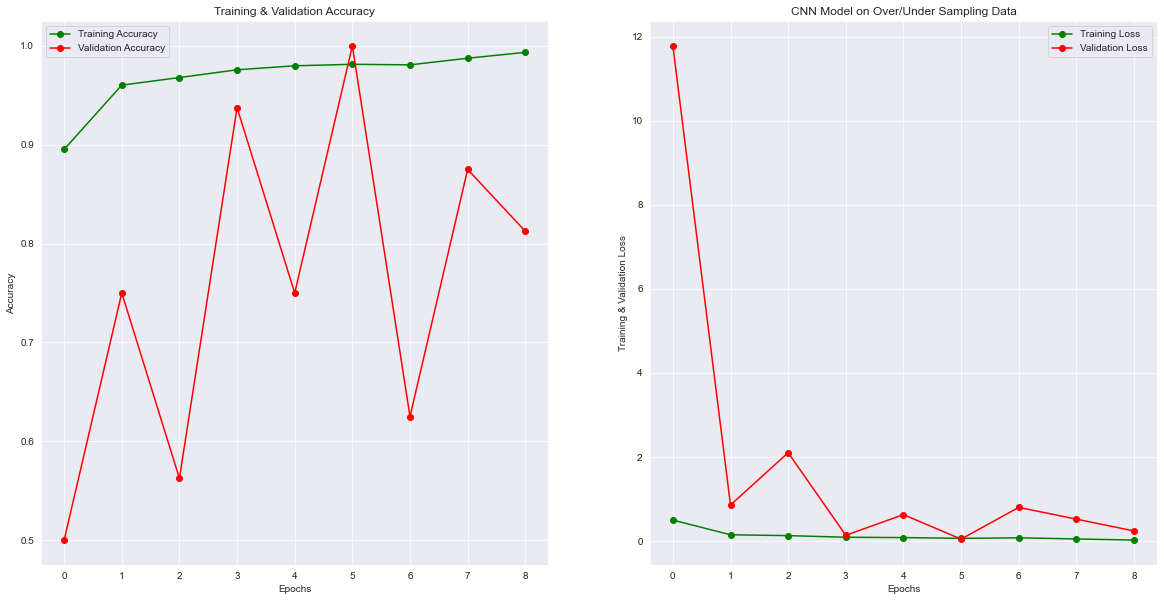

In [ ]:
plot_accuracy(9, history_cnn_3)

4) Fit CNN with Adjusting Class Weights

In [ ]:
# Clone original CNN model for Adjusting Class Weights
cnn_model_AW = keras.models.clone_model(cnn_model)
cnn_model_AW.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# Fit model
history_cnn_4 = cnn_model_AW.fit(x_train, y_train, 
                                 class_weight = class_weight,
                                 batch_size = 32,
                                 epochs = 12, 
                                 validation_data = (x_val, y_val),
                                 callbacks = callback_list)

Epoch 1/12
163/163 [==============================] - 126s 770ms/step - loss: 0.8240 - accuracy: 0.8698 - val_loss: 29.5203 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 123s 757ms/step - loss: 0.3157 - accuracy: 0.9415 - val_loss: 65.2400 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2196 - accuracy: 0.9582
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 125s 767ms/step - loss: 0.2196 - accuracy: 0.9582 - val_loss: 9.1482 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 124s 760ms/step - loss: 0.0724 - accuracy: 0.9835 - val_loss: 2.0901 - val_accuracy: 0.6875
Epoch 5/12
163/163 [==============================] - 124s 761ms/step - loss: 0.0485 - accuracy: 0.9887 - val_loss: 0.1387 - val_accuracy: 0.8750
Epoch 6/12
163/163 [==============================] - 124s 763ms/step - loss: 0.0333 - accuracy: 0.9927

In [ ]:
# Save model
cnn_model_AW.save('cnn_model_AW.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", cnn_model_AW.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", cnn_model_AW.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 1s 74ms/step - loss: 3.6831 - accuracy: 0.7516
Loss of the model is -  3.68308424949646
20/20 [==============================] - 2s 75ms/step - loss: 3.6831 - accuracy: 0.7516
Accuracy of the model is -  75.16025900840759 %


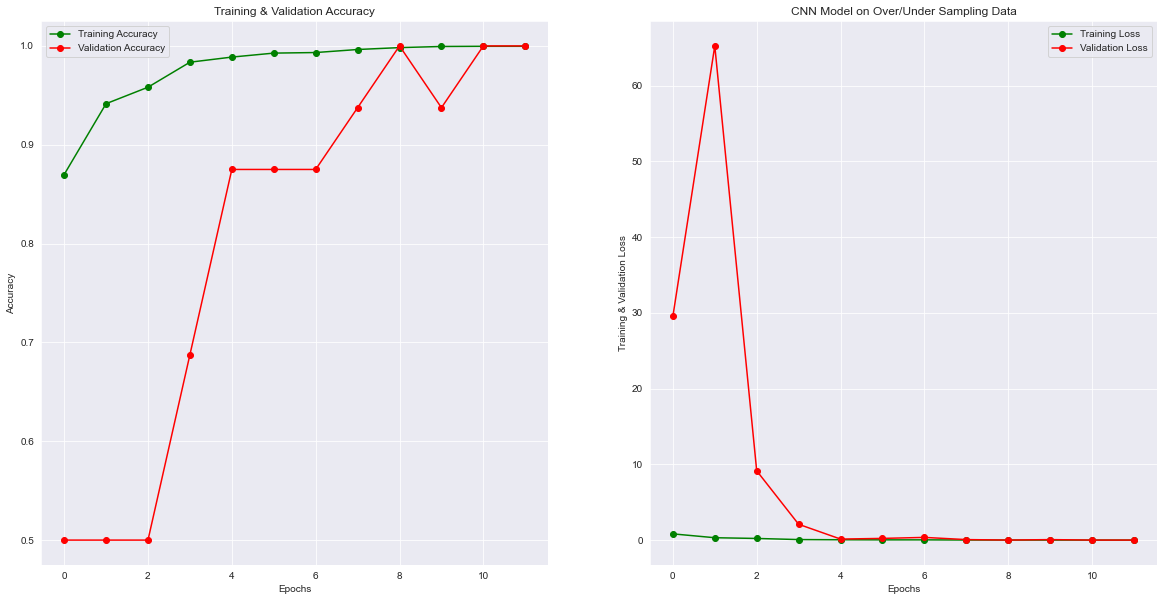

In [ ]:
plot_accuracy(12, history_cnn_4)

### Transfer Learning Models

#### VGG16

In [ ]:
from keras.models import Sequential, Model

NUM_CLASSES = 2
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(img_size, img_size, 3))
# include_top = False: not to include the 3 fully-connected layers at the top of the network.
# weights: None (random initialization), 'imagenet' (pre-training on ImageNet)

for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
    
x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)
vgg_model = Model(inputs=base_model.input, outputs=x)

vgg_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

1) Fit VGG model with adjusted class weights.

In [ ]:
# Clone original VGG model
vgg_model_AW = keras.models.clone_model(vgg_model)

# Compile using Adam optimizer
vgg_model_AW.compile(loss='categorical_crossentropy',  
                     optimizer=keras.optimizers.Adam(lr=0.0001), 
                     metrics=['accuracy'])

In [ ]:
# Convert y to categorical data
y_train_vgg = keras.utils.to_categorical(y_train, num_classes = 2)
y_test_vgg = keras.utils.to_categorical(y_test, num_classes = 2)
y_val_vgg = keras.utils.to_categorical(y_val, num_classes = 2)

In [ ]:
# Fit the model
history_vgg_1 = vgg_model_AW.fit(x_train, y_train_vgg,
                                 epochs = 8, 
                                 class_weight = class_weight, 
                                 validation_data = (x_val, y_val_vgg), 
                                 verbose = 1, 
                                 callbacks = callback_list)

Epoch 1/8
163/163 [==============================] - 177s 1s/step - loss: 0.5092 - accuracy: 0.8305 - val_loss: 0.6151 - val_accuracy: 0.5625
Epoch 2/8
163/163 [==============================] - 175s 1s/step - loss: 0.2451 - accuracy: 0.9398 - val_loss: 0.4414 - val_accuracy: 0.6875
Epoch 3/8
163/163 [==============================] - 173s 1s/step - loss: 0.2030 - accuracy: 0.9469 - val_loss: 0.3756 - val_accuracy: 0.7500
Epoch 4/8
163/163 [==============================] - 171s 1s/step - loss: 0.1783 - accuracy: 0.9513 - val_loss: 0.3206 - val_accuracy: 0.8125
Epoch 5/8
163/163 [==============================] - 175s 1s/step - loss: 0.1657 - accuracy: 0.9576 - val_loss: 0.2758 - val_accuracy: 0.9375
Epoch 6/8
163/163 [==============================] - 185s 1s/step - loss: 0.1598 - accuracy: 0.9569 - val_loss: 0.5659 - val_accuracy: 0.6250
Epoch 7/8
163/163 [==============================] - 181s 1s/step - loss: 0.1476 - accuracy: 0.9618 - val_loss: 0.5844 - val_accuracy: 0.5625
Epoch 

In [ ]:
# Save model
vgg_model_AW.save('vgg_model_AW.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", vgg_model_AW.evaluate(x_test, y_test_vgg)[0])
print("Accuracy of the model is - ", vgg_model_AW.evaluate(x_test, y_test_vgg)[1]*100, "%")

20/20 [==============================] - 16s 797ms/step - loss: 0.5268 - accuracy: 0.8141
Loss of the model is -  0.5267817378044128
20/20 [==============================] - 16s 787ms/step - loss: 0.5268 - accuracy: 0.8141
Accuracy of the model is -  81.41025900840759 %


In [ ]:
plot_accuracy(8, history_vgg_1)

2) Fit VGG model with ImageDataGenerator.

In [ ]:
# Clone original VGG model
vgg_model_IDG = keras.models.clone_model(vgg_model)

# Compile using Adam optimizer
vgg_model_IDG.compile(loss='categorical_crossentropy',  
                      optimizer=keras.optimizers.Adam(lr=0.0001), 
                      metrics=['accuracy'])

In [ ]:
# Fit the model
history_vgg_2 = vgg_model_IDG.fit(datagen.flow(x_train, y_train_vgg, batch_size = 32),
                                  epochs = 8, 
                                  class_weight = class_weight, 
                                  validation_data = (x_val, y_val_vgg), 
                                  verbose = 1, 
                                  callbacks = callback_list)

Epoch 1/8
163/163 [==============================] - 175s 1s/step - loss: 0.8521 - accuracy: 0.6515 - val_loss: 0.5890 - val_accuracy: 0.6875
Epoch 2/8
163/163 [==============================] - 180s 1s/step - loss: 0.5088 - accuracy: 0.8432 - val_loss: 0.4939 - val_accuracy: 0.7500
Epoch 3/8
163/163 [==============================] - 187s 1s/step - loss: 0.4446 - accuracy: 0.8623 - val_loss: 0.4063 - val_accuracy: 0.8750
Epoch 4/8
163/163 [==============================] - 179s 1s/step - loss: 0.4035 - accuracy: 0.8796 - val_loss: 0.4719 - val_accuracy: 0.7500
Epoch 5/8
163/163 [==============================] - 181s 1s/step - loss: 0.3955 - accuracy: 0.8838 - val_loss: 0.3912 - val_accuracy: 0.8750
Epoch 6/8
163/163 [==============================] - 180s 1s/step - loss: 0.3811 - accuracy: 0.8896 - val_loss: 0.3819 - val_accuracy: 0.8750
Epoch 00006: early stopping


In [ ]:
# Save model
vgg_model_IDG.save('vgg_model_IDG.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", vgg_model_IDG.evaluate(x_test, y_test_vgg)[0])
print("Accuracy of the model is - ", vgg_model_IDG.evaluate(x_test, y_test_vgg)[1]*100, "%")

20/20 [==============================] - 17s 826ms/step - loss: 0.3078 - accuracy: 0.8478
Loss of the model is -  0.3078063428401947
20/20 [==============================] - 16s 799ms/step - loss: 0.3078 - accuracy: 0.8478
Accuracy of the model is -  84.77563858032227 %


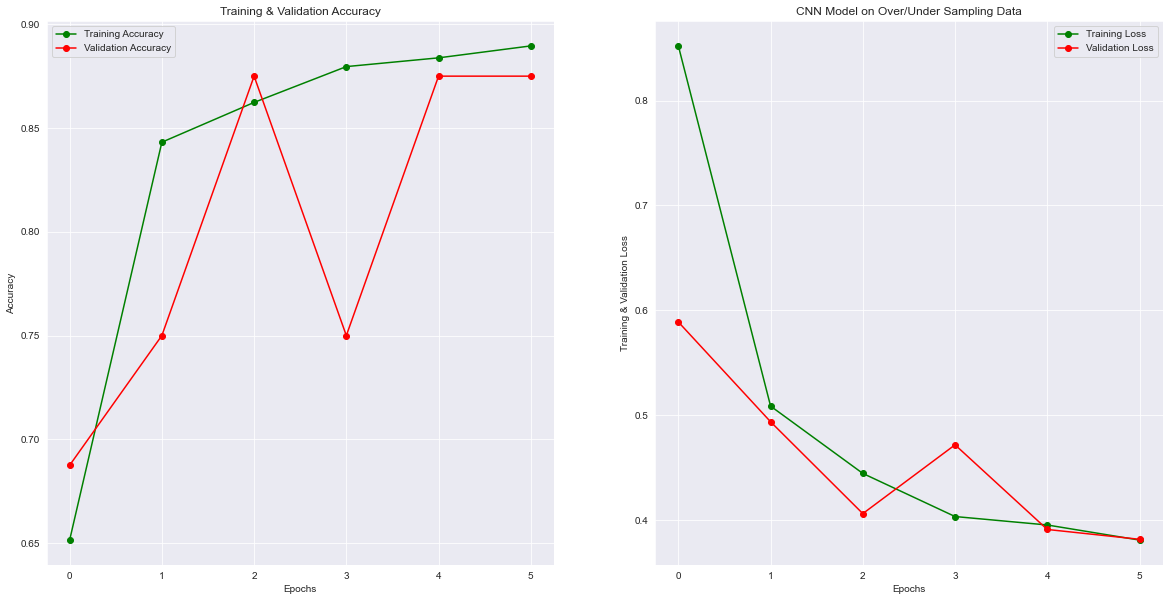

In [ ]:
plot_accuracy(6, history_vgg_2)

#### Inception V3

In [ ]:
# create the base pre-trained model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dropout , GlobalAveragePooling2D

base_model = InceptionV3(weights = None, # None: random initialization
                         include_top = False, # not to include the fully-connected at the top (last layer)
                         input_shape = (img_size, img_size, 3))

for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
    
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

inception_model = Model(inputs=base_model.input, outputs=predictions)

inception_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 74, 74, 32)   96          conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_104[0][0]    
_______________________________________________________________________________________

1) Fit Inception model with adjusted class weights.

In [ ]:
# Clone original Inception model 
inception_model_AW = keras.models.clone_model(inception_model)

# Compile using Adam optimizer
inception_model_AW.compile(loss='binary_crossentropy', 
                           optimizer='adam', 
                           metrics=['accuracy'])

# Fit model
history_inception_1 = inception_model_AW.fit(x_train, y_train, 
                                             validation_data = (x_val , y_val),
                                             class_weight = class_weight, 
                                             epochs = 8,
                                             callbacks = callback_list)

Epoch 1/8
163/163 [==============================] - 181s 1s/step - loss: 0.3454 - accuracy: 0.9062 - val_loss: 2.3353 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 181s 1s/step - loss: 0.2036 - accuracy: 0.9490 - val_loss: 2.8188 - val_accuracy: 0.5000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9674
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 181s 1s/step - loss: 0.1349 - accuracy: 0.9674 - val_loss: 2.4938 - val_accuracy: 0.5000
Epoch 4/8
163/163 [==============================] - 181s 1s/step - loss: 0.0903 - accuracy: 0.9795 - val_loss: 0.8881 - val_accuracy: 0.6875
Epoch 5/8
163/163 [==============================] - 188s 1s/step - loss: 0.0526 - accuracy: 0.9881 - val_loss: 0.0978 - val_accuracy: 1.0000
Epoch 6/8
163/163 [==============================] - 185s 1s/step - loss: 0.0617 - accuracy: 0.9839 - val_loss: 0.1901 - val_

In [ ]:
# Save model
inception_model_AW.save('inception_model_AW.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", inception_model_AW.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", inception_model_AW.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 4s 182ms/step - loss: 0.8410 - accuracy: 0.7933
Loss of the model is -  0.8409653902053833
20/20 [==============================] - 4s 185ms/step - loss: 0.8410 - accuracy: 0.7933
Accuracy of the model is -  79.32692170143127 %


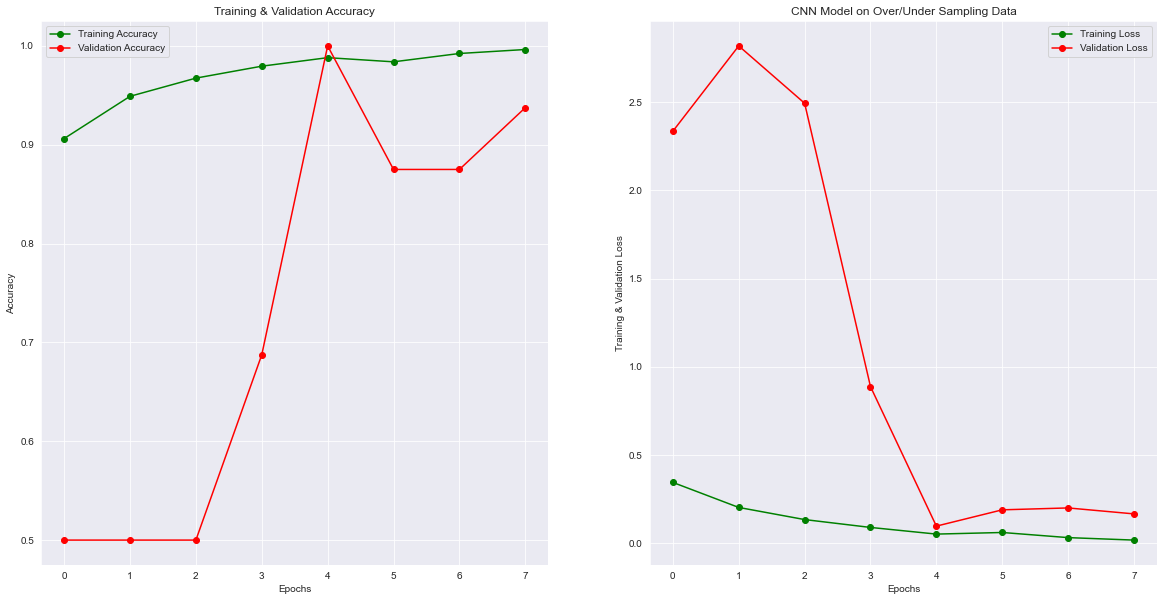

In [ ]:
plot_accuracy(8, history_inception_1)

2) Fit Inception model with ImageDataGenerator.

In [ ]:
# Clone original Inception model
inception_model_IDG = keras.models.clone_model(inception_model)

# Compile using Adam optimizer
inception_model_IDG.compile(loss='binary_crossentropy',  
                            optimizer='adam',
                            metrics=['accuracy'])

# Fit the model
history_inception_2 = inception_model_IDG.fit(datagen.flow(x_train, y_train, batch_size = 32),
                                              epochs = 8,
                                              validation_data = (x_val, y_val), 
                                              verbose = 1, 
                                              callbacks = callback_list)

Epoch 1/8
163/163 [==============================] - 182s 1s/step - loss: 0.3702 - accuracy: 0.8539 - val_loss: 2.2515 - val_accuracy: 0.5000
Epoch 2/8
163/163 [==============================] - 183s 1s/step - loss: 0.2409 - accuracy: 0.9011 - val_loss: 2.0629 - val_accuracy: 0.5000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9229
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 183s 1s/step - loss: 0.2003 - accuracy: 0.9229 - val_loss: 1.8147 - val_accuracy: 0.5000
Epoch 4/8
163/163 [==============================] - 183s 1s/step - loss: 0.1656 - accuracy: 0.9381 - val_loss: 1.4336 - val_accuracy: 0.5625
Epoch 5/8
163/163 [==============================] - 183s 1s/step - loss: 0.1544 - accuracy: 0.9429 - val_loss: 1.2066 - val_accuracy: 0.5625
Epoch 6/8
163/163 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9452
Epoch 00006: ReduceLROnPlateau

In [ ]:
# Save model
inception_model_IDG.save('inception_model_IDG.h5')

In [ ]:
# Evaluate the model using test dataset
print("Loss of the model is - ", inception_model_IDG.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", inception_model_IDG.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 3s 164ms/step - loss: 0.3198 - accuracy: 0.8958
Loss of the model is -  0.3198290467262268
20/20 [==============================] - 3s 152ms/step - loss: 0.3198 - accuracy: 0.8958
Accuracy of the model is -  89.58333134651184 %


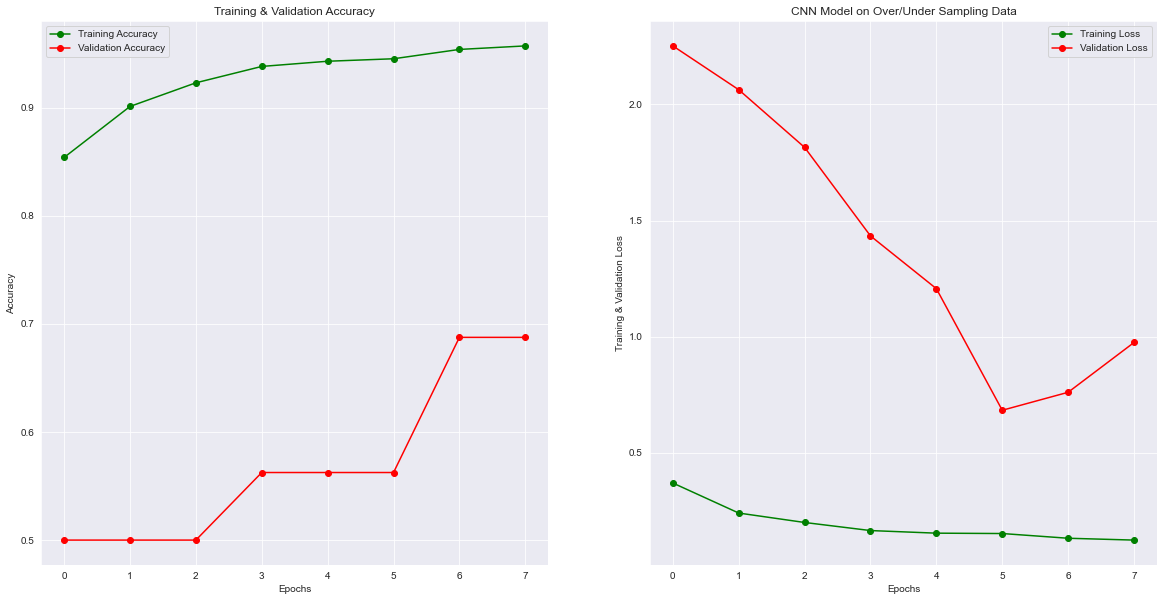

In [ ]:
plot_accuracy(8, history_inception_2)